<a href="https://colab.research.google.com/github/AlaaIraqy/Image_segmentation/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset


In [ ]:
from sklearn.cluster import KMeans
import matplotlib
import sklearn
import numpy as np
import os
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile, join
import cv2
import scipy.io
from PIL import Image
import math
from operator import itemgetter
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sklearn import preprocessing


In [ ]:
os.chdir('/content')
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=6dee834a19b94b1dea72ddd2f345aef2cd538a2248909972d035da37b84a8fb9
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5688        515  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3142        274  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1102         97  1.0              
dhruvildave/wikibooks-dataset                           

In [ ]:
!kaggle datasets download -d balraj98/berkeley-segmentation-dataset-500-bsds500
! mkdir dataset
! unzip berkeley-segmentation-dataset-500-bsds500.zip -d dataset

 88% 49.0M/56.0M [00:00<00:00, 48.2MB/s]
100% 56.0M/56.0M [00:00<00:00, 94.2MB/s]
Archive:  berkeley-segmentation-dataset-500-bsds500.zip
  inflating: dataset/ground_truth/test/100007.mat  
  inflating: dataset/ground_truth/test/100039.mat  
  inflating: dataset/ground_truth/test/100099.mat  
  inflating: dataset/ground_truth/test/10081.mat  
  inflating: dataset/ground_truth/test/101027.mat  
  inflating: dataset/ground_truth/test/101084.mat  
  inflating: dataset/ground_truth/test/102062.mat  
  inflating: dataset/ground_truth/test/103006.mat  
  inflating: dataset/ground_truth/test/103029.mat  
  inflating: dataset/ground_truth/test/103078.mat  
  inflating: dataset/ground_truth/test/104010.mat  
  inflating: dataset/ground_truth/test/104055.mat  
  inflating: dataset/ground_truth/test/105027.mat  
  inflating: dataset/ground_truth/test/106005.mat  
  inflating: dataset/ground_truth/test/106047.mat  
  inflating: dataset/ground_truth/test/107014.mat  
  inflating: dataset/ground_tru

In [ ]:
ground_truth_train_path = '/content/dataset/ground_truth/train'
ground_truth_test_path = '/content/dataset/ground_truth/test'
images_test_path = '/content/dataset/images/test'
images_train_path = '/content/dataset/images/train'

def get_samples(path,string):
  samples_data = [f for f in os.listdir(path) if isfile(join(path, f)) and f.endswith(string)]
  samples_data=sorted(samples_data)
  return samples_data


def get_images(sample_data,sample_path):
  data=[]
  for image in sample_data:
    img_path = os.path.join(sample_path,image)
    img = cv2.imread(img_path)
    img = np.array(img)
    for i in range(len(img)):
      for j in range(len(img[i])):
        img[i][j][0],img[i][j][2] = img[i][j][2], img[i][j][0]
    data.append(img)
    np_data = np.array(data)
  return np_data

def load_mat_file(samples_data,sample_path):
  l=[]
  for d in samples_data:
    # img_path = os.path.join(sample_path,d)
    img_path = sample_path + f'/{d}'
    mat = scipy.io.loadmat(img_path)
    #each mat file has header,version,globals and groundTruth but we are interested only in groundTruth.
    l.append(mat['groundTruth'])
  return l


#take only 50 samples from test samples as required in the pdf.
train_set = np.array(get_samples(images_train_path,".jpg"))
test_set=np.array(get_samples(images_test_path,".jpg"))[:50]
ground_truth_train_list = np.array(get_samples(ground_truth_train_path,".mat"))
ground_truth_test_list = np.array(get_samples(ground_truth_test_path,".mat"))[:50]

#get the images.
training_images=get_images(train_set, images_train_path)
test_images=get_images(test_set, images_test_path)

#load the mat file which includes the groundTruth images.
ground_truth_training = load_mat_file(ground_truth_train_list , ground_truth_train_path)
ground_truth_test = load_mat_file(ground_truth_test_list , ground_truth_test_path)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# 2.a Show image and its ground truth segmentation




In [ ]:
def show_img_and_segmentation(image_no):
  show_image(test_images[image_no],"Original image")
  show_segmentation(image_no)

def show_image(img,title=""):
  plt.title(title)
  plt.imshow(img)
  plt.show()

def show_segmentation(image_no):
  segments_number = ground_truth_test[image_no].size
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
  for ax,segment in zip(axes.flatten(),range(segments_number)):
    #show_image(ground_truth_test[image_no][0][segment][0][0][1],f"Segmentation image {segment+1}")
    ax.set_title(f"Segmentation image {segment+1}")
    ax.imshow(ground_truth_test[image_no][0][segment][0][0][1])
    #ax.show()

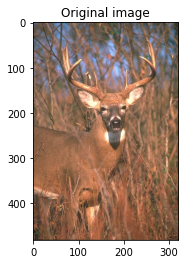

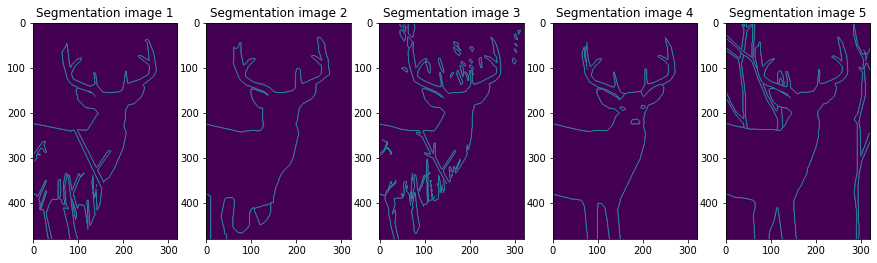

In [ ]:
show_img_and_segmentation(10)

# K-Means

In [ ]:
def perform_k_means(image_no, k, n_features):
  img = test_images[image_no]
  if n_features == 3:
    img_2d = img.reshape((-1,3))
  elif n_features == 5:
    img_2d = convert_rgb_to_spatial(img)
  else:
    print('n_features is not valid')
    return

  kmeans = KMeans(n_clusters = k).fit(img_2d)
  labels = kmeans.labels_
  centers = np.uint8(kmeans.cluster_centers_)
  clustered_image = np.uint8(np.zeros((len(img), len(img[0]), n_features)))
  idx = 0
  for i in range(len(img)):
    for j in range(len(img[0])):
      clustered_image[i][j] = centers[labels[idx]]
      idx+=1
  if n_features == 5:
      clustered_image = convert_spatial_to_rgb(img, clustered_image, k)
  return clustered_image, labels
  


In [ ]:
K = [3,5,7,9,11]
# K = [3,5,7]
# image_no = [1,2,3,4,5]
for image_no in range(50):
  clustered_images = []
  fig = plt.figure(figsize =(20,5))
  for k in K:
    clustered_image, labels = perform_k_means(image_no, k, 3)
    clustered_images.append(clustered_image)
    # show_image(clustered_image, f'Clustered image, k = {k}')
    M = ground_truth_test[image_no][0].size
    total_f_measure = 0
    total_entropy = 0
    for segment_no in range(M):
      y_true = ground_truth_test[image_no][0][segment_no][0][0][0].flatten()
      y_pred = labels
      f_measure = calculate_F_measure(y_true, y_pred)
      entropy = conditional_entropy(y_true, y_pred)
      total_f_measure += f_measure
      total_entropy += entropy
      print(f'image {image_no}, k= {k}, segment {segment_no}, F-measure= {f_measure}, Entropy= {entropy}')
    print(f'Average for image {image_no}, k = {k}, F-measure = {total_f_measure/M}, Entropy = {total_entropy/M}')
  for x in range(len(K)):
    fig.add_subplot(1,len(K), x+1)
    plt.imshow(Image.fromarray(clustered_images[x]))
    plt.axis('off')
    plt.title(f'k = {K[x]}')
  plt.show()
    # print('Conditional Entropy = ', )


In [ ]:
def calculate_F_measure(ground_truth, labels):
  n_clusters = len(np.unique(labels))
  n_classes = len(np.unique(ground_truth))
  prec = np.zeros((n_clusters, 1)) #purity
  rec = np.zeros((n_clusters, 1))
  A = np.zeros((n_clusters, n_classes))
  F = 0
  n = len(labels)
  for i in range(n):
    A[labels[i]][ground_truth[i]-1] += 1
  for i in range(n_clusters):
    prec[i] = np.max(A[i]) / np.sum(A[i])
    dominant_i = np.argmax(A[i])
    T = np.sum(A[:,dominant_i])
    rec[i] = A[i][dominant_i] / T
    F += (2*prec[i]*rec[i]) / (prec[i] + rec[i])
  F = F / n_clusters
  return F

In [ ]:
def conditional_entropy(ground_truth, labels):
  n_clusters = len(np.unique(labels))
  n_classes = len(np.unique(ground_truth))
  n = len(labels)
  A = np.zeros((n_clusters, n_classes))
  for i in range(n):
    A[labels[i]][ground_truth[i]-1] += 1
  HTCi = np.zeros((n_clusters, 1))
  for i in range(n_clusters):
    sum = np.sum(A[i])
    for j in range(n_classes):
      if A[i][j] == 0:
        continue
      HTCi[i] += -(A[i][j]/sum)*math.log(A[i][j]/sum, 10)
  # compute average
  ret = 0
  for i in range(n_clusters):
    ret += (np.sum(A[i])/n)*HTCi[i]
  return ret

# Part 4

In [ ]:

Normalized_cut_trainingset=test_images[1:6]

cluster_no=5
k_val=5
scale=0.2
id=1
for i in range(len(Normalized_cut_trainingset)):
  k_mean_image,lab=perform_k_means(id, k_val, 3)
  print("image number: ",i+1)
  show_image(ground_truth_test[id][0][k_val-1][0][0][0],f"ground truth image {k_val}")
  show_image(ground_truth_test[id][0][k_val-1][0][0][1],f"Segmentation image {k_val}")
  id+=1
  show_image(k_mean_image, f'K-mean image')

  height=Normalized_cut_trainingset[i].shape[0]
  width=Normalized_cut_trainingset[i].shape[1]
  
  Nr = cv2.resize(Normalized_cut_trainingset[i], (int(width * scale),int(height * scale)), interpolation = cv2.INTER_AREA)


  Nr=Nr.reshape((-1,3))
  imagesize=Nr.shape[0]


  #calculating similarity matrix using 5 nearest neighbours 
  simalrity_matrix=np.zeros((imagesize,imagesize))
  simalrity_matrix=np.array(kneighbors_graph(Nr,k_val,mode='connectivity',include_self=False).toarray())

  for i in range(len(Nr)):
    for j in range(len(Nr)):
      simalrity_matrix[i][j] = max(simalrity_matrix[i][j], simalrity_matrix[j][i])
  
  G = nx.from_numpy_matrix(simalrity_matrix)
  L = nx.laplacian_matrix(G).toarray()
  Delta = L+simalrity_matrix
  B = np.dot(np.linalg.inv(Delta), L)

  La=np.dot(np.linalg.inv(degree_matrix),B)

  eigenVal,eigenVec=np.linalg.eigh(La)
  U=eigenVec[:,0:k_val]
  Y = preprocessing.normalize(U, norm='l2')

  kmeans = KMeans(n_clusters = cluster_no).fit(Y)
  labels=kmeans.labels_
  
  centers=np.zeros((cluster_no,3))
  for j in range(0,cluster_no):
    indeces_equal_label=np.array(np.where(labels==j))
    indices=np.array(Nr[indeces_equal_label,:]).reshape(-1,3)
    centers[j]=np.average(indices,axis=0)

  centers = centers.astype(int)
  centers=np.uint8(centers)

  clustered_image=np.uint8(np.zeros((int(height*scale),int(width*scale),3)))
  idx=0
  for m in range(clustered_image.shape[0]):
    for j in range(clustered_image.shape[1]):
      clustered_image[m][j]=centers[labels[idx]]
      idx+=1

  show_image(clustered_image,"Normalized cut image")



# Part 5

In [ ]:
from matplotlib.colors import to_rgb 
def convert_rgb_to_spatial(img):
  x = len(img)
  y = len(img[0])
  ret = np.zeros((x*y,5))
  idx = 0
  for i in range(x):
    for j in range(y):
      ret[idx][0:3] = img[i][j]
      ret[idx][3] = i
      ret[idx][4] = j
      idx += 1
  return ret

def convert_spatial_to_rgb(img, s_i, k):
  dim = np.shape(img)
  ret = np.zeros(dim)
  x = len(ret)
  y = len(ret[0])
  colors = ['gray','red','greenyellow','pink','blue','orange','cyan','whitesmoke','purple','silver','maroon']
  color_index = 0
  d = dict() # key: (1,2,3,4,5) val : color string
  for i in range(x):
    for j in range(y):
      t = str((s_i[i][j][0],s_i[i][j][1],s_i[i][j][2],s_i[i][j][3],s_i[i][j][4]))
      if t not in d:
        color_rgb = matplotlib.colors.to_rgb(colors[color_index])
        d[t] = np.array(tuple(i * 255 for i in (color_rgb)))
        color_index += 1
      ret[i][j] = d[t]
  ret = np.array(ret).astype(np.uint8)
  return ret


image number:  1


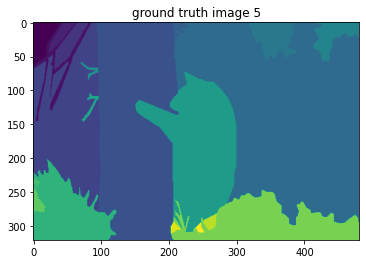

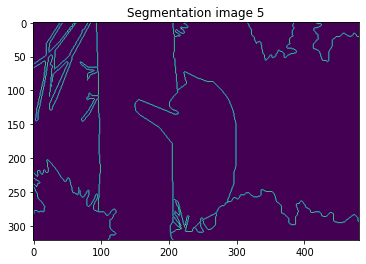

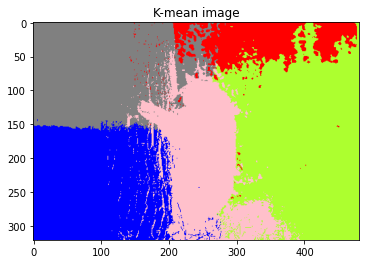

image number:  2


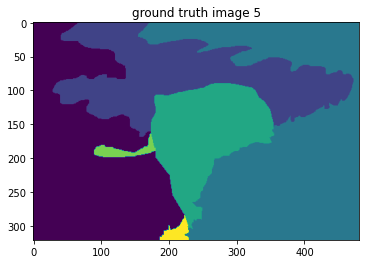

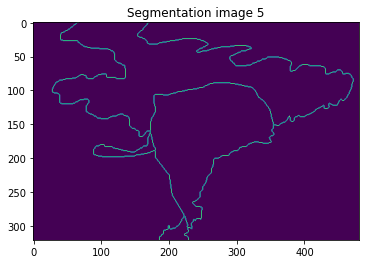

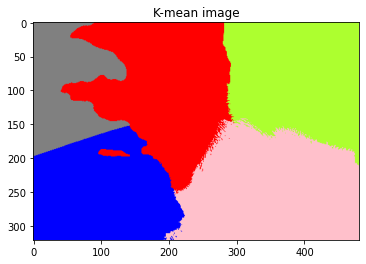

image number:  3


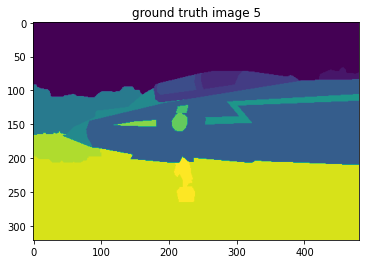

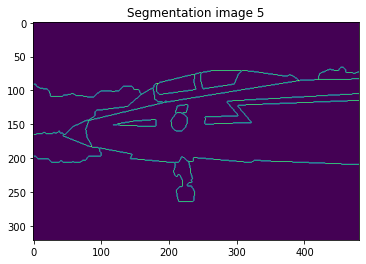

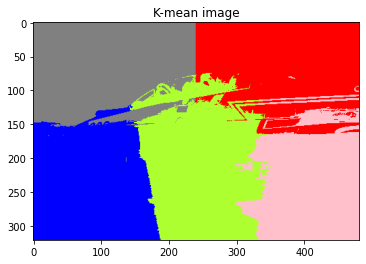

image number:  4


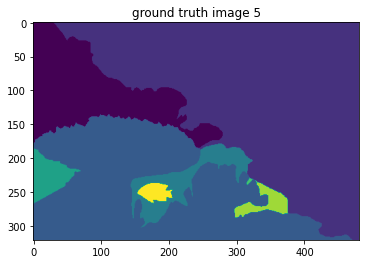

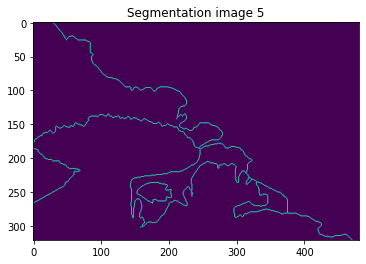

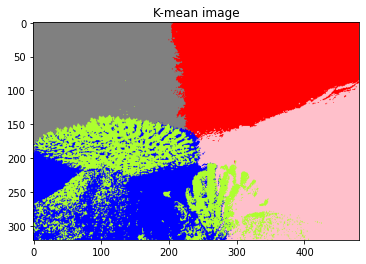

image number:  5


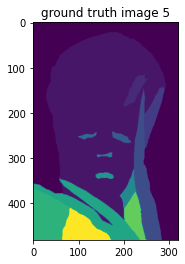

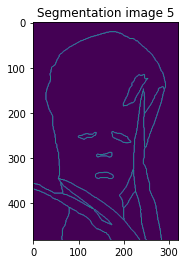

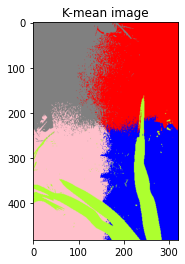

In [ ]:
part5_trainingset=test_images[1:6]
cluster_no=5
k_val=5
id=1
for i in range(len(part5_trainingset)):
  k_mean_image,lab=perform_k_means(id, k_val, 5)
  print("image number: ",i+1)
  show_image(ground_truth_test[id][0][k_val-1][0][0][0],f"ground truth image {k_val}")
  show_image(ground_truth_test[id][0][k_val-1][0][0][1],f"Segmentation image {k_val}")
  id+=1
  show_image(k_mean_image, f'K-mean image')